In [1]:
#!/usr/bin/env python
import sys
import os
import pickle as pkl
import warnings
import time
import glob

from functools import wraps, partial
from pathlib import Path
from multiprocessing import cpu_count
from multiprocessing.pool import Pool as Pool

import numpy as np
import matplotlib.pyplot as plt


from AnalyseCID import AnalyseCID
from utils import *
from utils_plot import *

sys.path.append('ComputableInformationDensity_dev')
from ComputableInformationDensity_dev.cid import interlaced_time, cid2d
from ComputableInformationDensity_dev.computable_information_density import cid, cid_shuffle
from ComputableInformationDensity_dev.hilbert_curve import hilbert_curve, itter_hscan

# Get absolute path to this notebook
notebook_path = Path().resolve()
parent_dir = notebook_path.parent
sys.path.append(str(parent_dir))
from NematicAnalysis.utils import gen_clustering_metadata, get_defect_arr_from_frame, calc_weighted_mean

plt.style.use('sg_article')
#plt.rcParams.update({"figure.figsize": (9,6)})
plt.rcParams.update({"text.usetex": True,})
plt.rcParams['legend.handlelength'] = 0


In [5]:
base_path = f'Z:\\cid\\na'
save_path = f'data\\nematic\\na'

extract = True
analyze = True
save_figs = True
verbose = True

data_suffix = ''  # 'sd', 'ndg' or ''    
use_seq = True

nbits = 7
cg = 4

data_dict = {}
sd_data_dict = {'data_suffix': 'sd',
    'output_suffix': f'_seq_nb{nbits}cg{cg}' if use_seq else f'_nb{nbits}cg{cg}',
    'uncertainty_multiplier': 20,
    'L_list': [512],
    'Nexp_list': [10],
    'act_exclude_dict': {512: []},
    'xlims': (0.016, 0.045),
    'act_critical': 0.022
    }

na_data_dict = {
    'data_suffix': '',
    'output_suffix': f'_nb{nbits}cg{cg}',
    'uncertainty_multiplier': 20,
    'L_list': [512, 1024, 2048],
    'Nexp_list': [5]*3,
    'act_exclude_dict': {512: [0.02, 0.0225], 1024: [], 2048: [0.0225]},
    'xlims': (0.016, 0.045),
    'act_critical': 0.022
}
naf_data_dict = {
    'data_suffix': 'f',
    'output_suffix': f'_nb{nbits}cg{cg}',
    'uncertainty_multiplier': 20,
    'L_list': [1024],
    'Nexp_list': [5],
    'act_exclude_dict': {1024: [0.0235],},
    'xlims': (0.016, 0.045),
    'act_critical': 0.022
}


ndg_data_dict = {
    'data_suffix': 'ndg',
    'output_suffix': f'_nb{nbits}cg{cg}',
    'uncertainty_multiplier': 20,
    'L_list': [1024],
    'Nexp_list': [1],
    'act_exclude_dict': {1024: []},
    'xlims': None,
    'act_critical': 0.65
    }

na_data_dict = {
    'data_suffix': '',
    'output_suffix': f'_nb{nbits}cg{cg}',
    'uncertainty_multiplier': 20,
    'L_list': [1024,2048],
    'Nexp_list': [5]*3,
    'act_exclude_dict': {1024: [], 2048: [0.0225]},
    'xlims': (0.016, 0.045),
    'act_critical': 0.022
    }

data_dict = {'sd': sd_data_dict, 'ndg': ndg_data_dict, '': na_data_dict, 'f': naf_data_dict}

cid_dict = {
    'base_path': base_path,
    'save_path': save_path,
    'nbits': nbits,
    'cg': cg,
    'verbose': verbose,
    'ddof': 1,
    **data_dict[data_suffix]
}
output_suffix = data_dict[data_suffix]['output_suffix']
fig_folder = 'na' if data_suffix == '' else data_suffix
figs_save_path = f'data\\nematic\\figs\\{fig_folder}\\{output_suffix[1:]}'
if not os.path.exists(figs_save_path): 
    os.makedirs(figs_save_path)


ac = AnalyseCID(cid_dict, load_data=not extract)

# Set figure save path
ac.figs_save_path = figs_save_path

if extract:
    ac.run()#conv_list_dir = r'C:\\Users\\Simon Andersen\\Projects\\Projects\\Thesis\\Universality\\data\\nematic\\na1024')
if analyze and not extract:
    ac.analyze()


=== Starting CID analysis ===
[Extract] LX=1024 | data_path=Z:\cid\na1024
cid data saved to data\nematic\na1024\cid_data_nb7cg4.npz
[Extract] LX=2048 | data_path=Z:\cid\na2048
cid_nb7cg4.npz not found in Z:\cid\na2048\analysis_zeta_0.08\zeta_0.08_counter_0, skipping...
cid_nb7cg4.npz not found in Z:\cid\na2048\analysis_zeta_0.08\zeta_0.08_counter_1, skipping...
cid_nb7cg4.npz not found in Z:\cid\na2048\analysis_zeta_0.08\zeta_0.08_counter_2, skipping...
cid_nb7cg4.npz not found in Z:\cid\na2048\analysis_zeta_0.08\zeta_0.08_counter_3, skipping...
cid_nb7cg4.npz not found in Z:\cid\na2048\analysis_zeta_0.08\zeta_0.08_counter_4, skipping...
cid data saved to data\nematic\na2048\cid_data_nb7cg4.npz
=== Extraction & Analysis complete ===


In [9]:
npz_path = r'C:\\Users\\Simon Andersen\\Projects\\Projects\\Thesis\\Universality\\data\\nematic\\na1024f\\cid_data_nb5cg4.npz'
data = np.load(npz_path, allow_pickle=True)
cidf = data['cid_minmax']
fracf = data['frac_minmax']


In [ ]:
plot_abs=True
ac.plot_cid_and_deriv(save_path=ac.figs_save_path, act_critical=cid_dict['act_critical'], xlims=cid_dict['xlims'], plot_abs=plot_abs);
ac.plot_div_and_deriv(save_path=ac.figs_save_path, act_critical=cid_dict['act_critical'], xlims=cid_dict['xlims'], plot_abs=plot_abs);

In [ ]:
plot_abs = True
ac.plot_cid_fluc(save_path=ac.figs_save_path, act_critical=cid_dict['act_critical'], xlims=cid_dict['xlims'], plot_abs=plot_abs);
ac.plot_div_fluc(save_path=ac.figs_save_path, act_critical=cid_dict['act_critical'], xlims=cid_dict['xlims'], plot_abs=plot_abs);

In [ ]:
ac.plot_cid_moments(save_path=ac.figs_save_path, act_critical=cid_dict['act_critical'], xlims=cid_dict['xlims'],);
ac.plot_div_moments(save_path=ac.figs_save_path, act_critical=cid_dict['act_critical'], xlims=cid_dict['xlims'],);

In [ ]:
#### Plot cid/div and derivatives
xlims=(0.016, 0.045)
fig, ax = ac.plot_cid_and_deriv(save_path=figs_save_path, xlims=xlims, plot_abs=True,);
fig1, ax1 = ac.plot_div_and_deriv(save_path=figs_save_path, xlims=xlims, plot_abs=True,);


In [ ]:
#### Plot cid/div fluc and derivatives
xlims=(0.016, 0.045)
fig, ax = ac.plot_cid_fluc(save_path=figs_save_path,xlims=xlims, plot_abs=True,);
fig1, ax1 = ac.plot_div_fluc(save_path=figs_save_path, xlims=xlims, plot_abs=True, plot_div_per=True);

In [ ]:
## Plot cid/div moments
xlims=(0.016, 0.045)
fig, ax = ac.plot_cid_moments(L_list=ac.L_list, save_path=figs_save_path, xlims=xlims,);
fig1, ax1 = ac.plot_div_moments(L_list=ac.L_list, save_path=figs_save_path, xlims=xlims,);

In [37]:
varff.shape

(25,)

(0.016, 0.045)

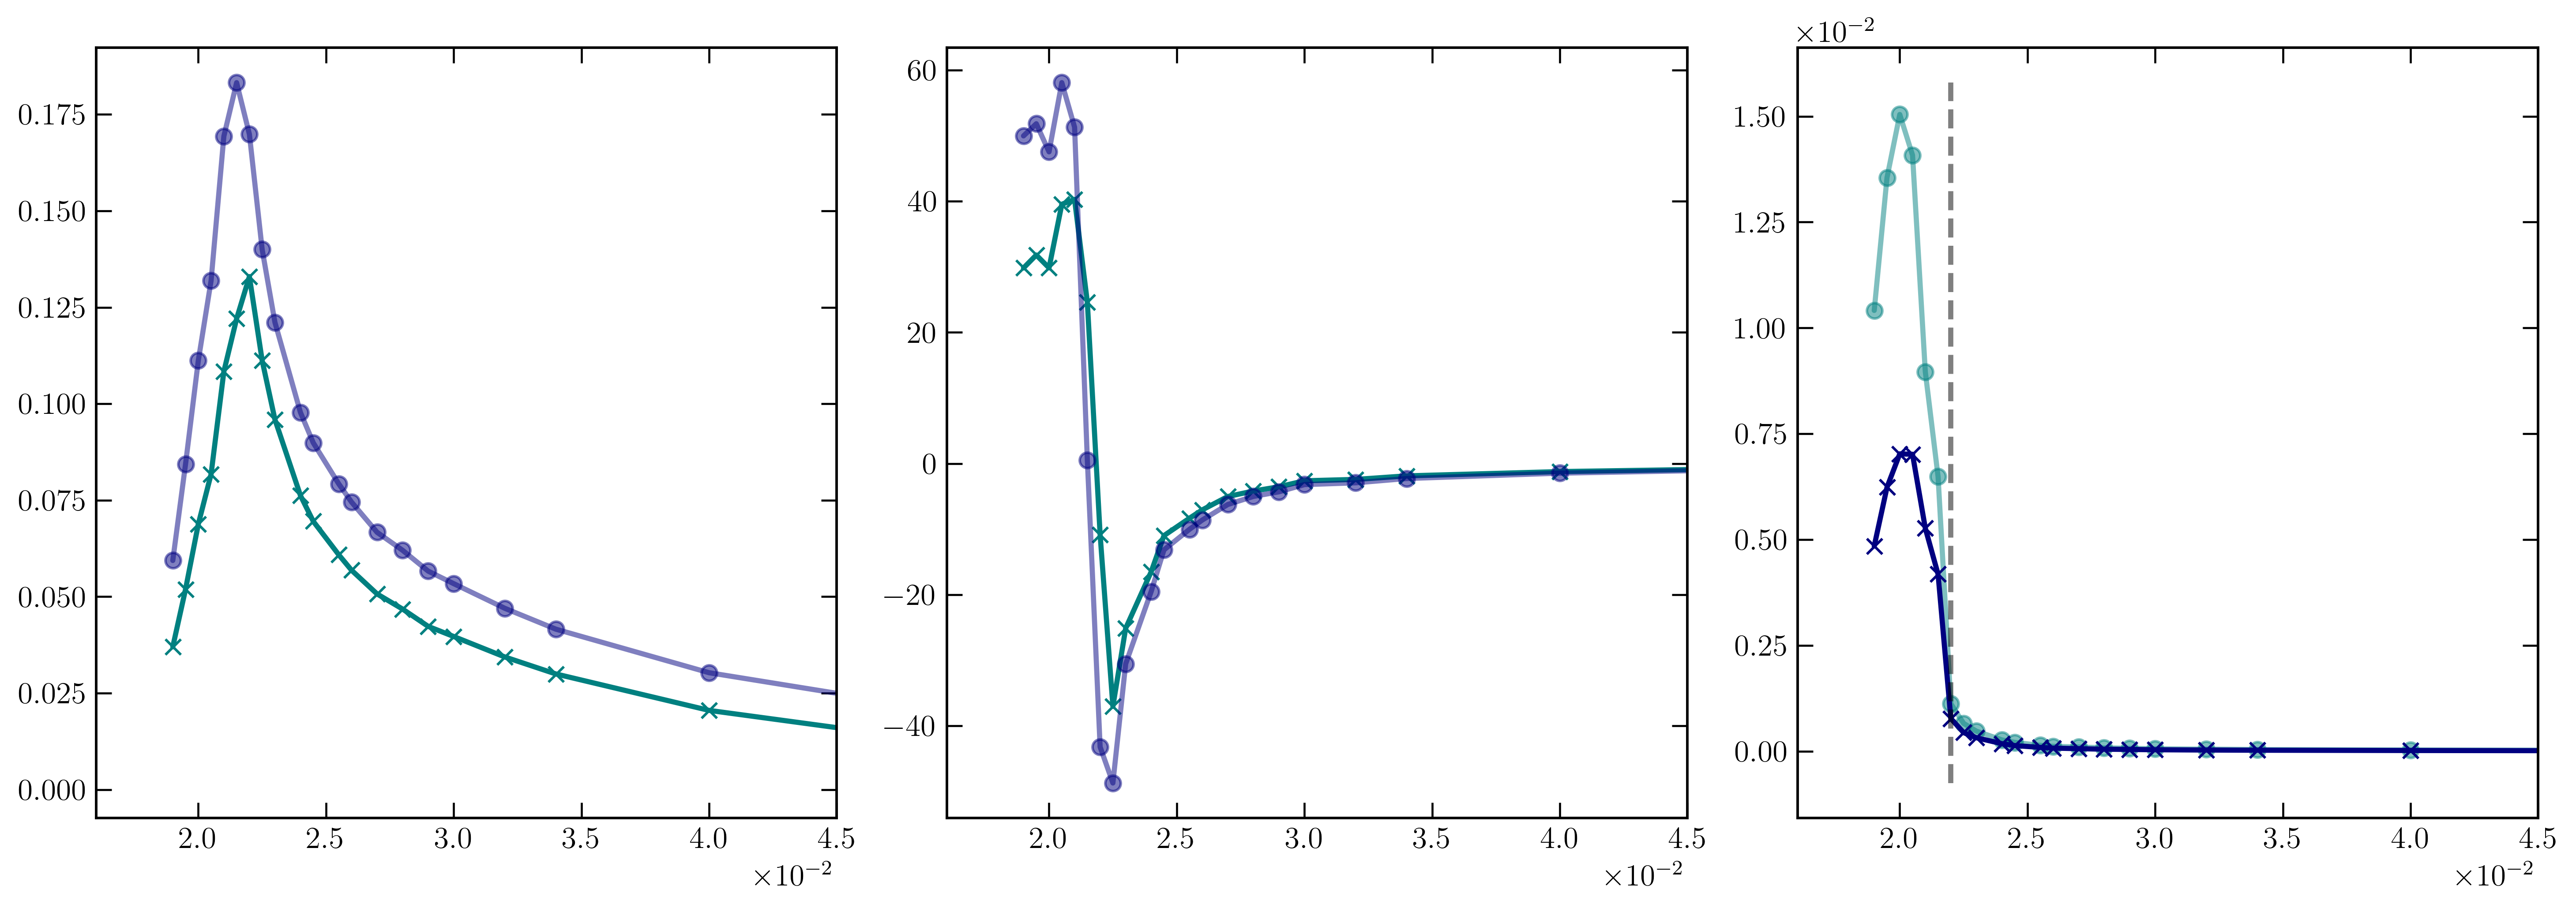

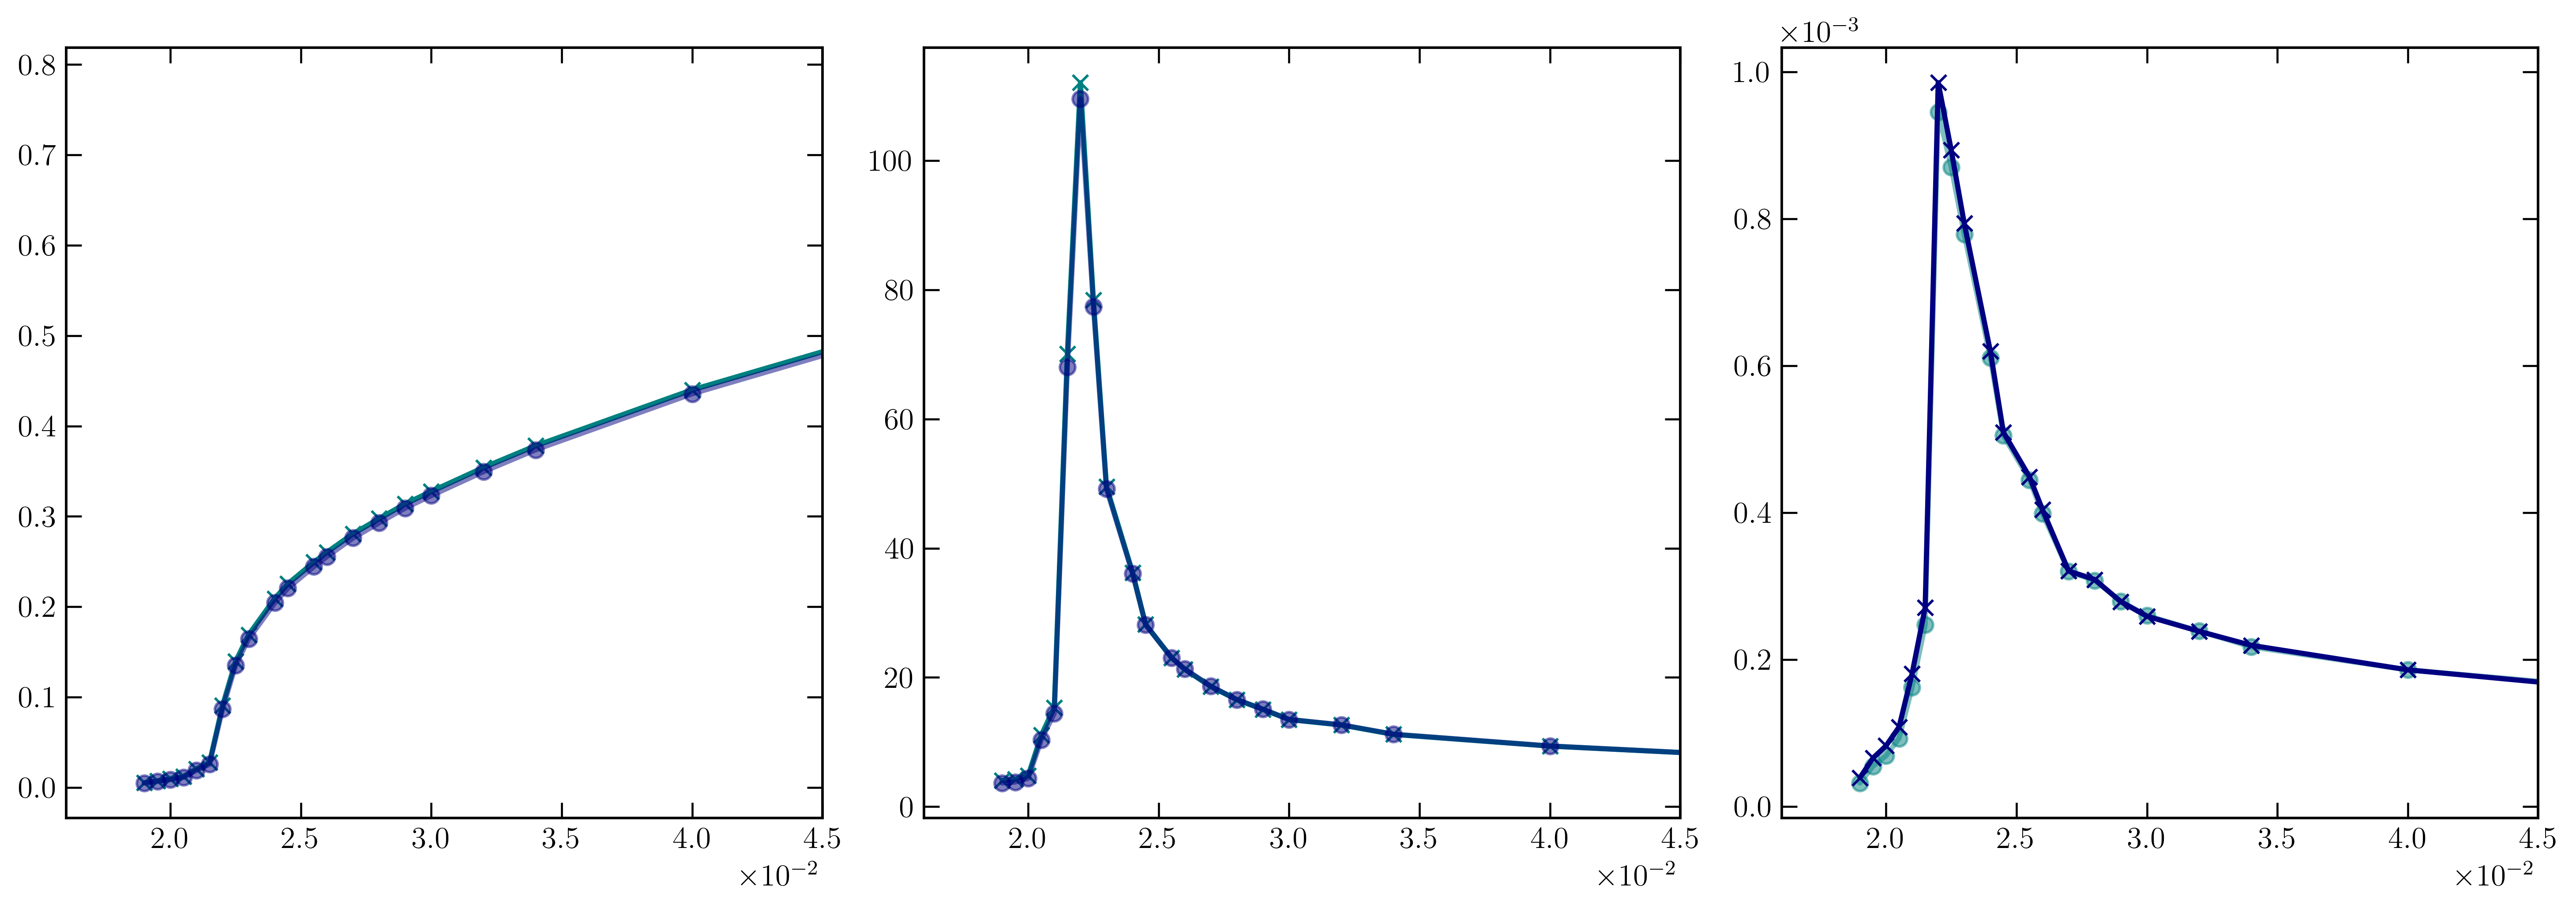

In [50]:


LX=1024
npz_path = r'C:\\Users\\Simon Andersen\\Projects\\Projects\\Thesis\\Universality\\data\\nematic\\na1024f\\cid_data_nb5cg4.npz'
data = np.load(npz_path, allow_pickle=True)
act_list = ac.act[LX]
cidf = data['cid_minmax']
fracf = data['frac_minmax']
cidf_tav, varf, varpf = calc_time_avs_ind_samples(cidf[...,0], ac.conv[ac.L_list[0]], Nexp=5,unc_multiplier=20,ddof=1)
fracf_tav, varff, varfpf = calc_time_avs_ind_samples(fracf[...,0], ac.conv[ac.L_list[0]], Nexp=5,unc_multiplier=20,ddof=1)
dcidf = calc_central_derivative(act_list, cidf_tav[:,0], cidf_tav[:,1])
dfracf = calc_central_derivative(act_list, fracf_tav[:,0], fracf_tav[:,1])

fig, ax = plt.subplots(ncols=3, figsize=(14,5))
ax[0].plot(act_list, 1-ac.frac_tav[LX][:,0], '-x')
ax[0].plot(act_list, 1-fracf_tav[:,0], '-o', alpha=0.5)
ax[0].set_xlim(0.016, 0.045)
ax[1].plot(act_list, -1*ac.dfrac[LX][:,0], '-x', label='df orig')
ax[1].plot(act_list, -1*dfracf[:,0], '-o', alpha=0.5, label='df min')
#ax[2].plot(act_list, varfpf[:,0]/(1-fracf_tav[:,0]), '-o', alpha=0.5, label='var min')
#ax[2].plot(act_list, ac.frac_var[LX][:,0]/(1-ac.frac_tav[LX][:,0]), '-x', label='var orig')
ax[2].plot(act_list, varfpf[:,0]/(1), '-o', alpha=0.5, label='var min')
ax[2].plot(act_list, ac.frac_var[LX][:,0]/(1), '-x', label='var orig')
ax[2].set_xlim(0.016, 0.045)    
ylim = ax[2].get_ylim()
ax[2].vlines(0.022, ylim[0],ylim[1],color='k', linestyle='--', alpha=0.5)

ax[1].set_xlim(0.016, 0.045)

fig2, ax2 = plt.subplots(ncols=3, figsize=(14,5))
ax2[0].plot(act_list, ac.cid_tav[LX][:,0], '-x')
ax2[0].plot(act_list, cidf_tav[:,0], '-o', alpha=0.5)
ax2[0].set_xlim(0.016, 0.045)
ax2[1].plot(act_list, ac.dcid[LX][:,0], '-x', label='NA-F')
ax2[1].plot(act_list, dcidf[:,0], '-o', alpha=0.5, label='NA-F')
ax2[1].set_xlim(0.016, 0.045)
ax2[2].plot(act_list, varpf[:,0], '-o', alpha=0.5, label='var min')
ax2[2].plot(act_list, ac.cid_var[LX][:,0], '-x', label='var orig')
ax2[2].set_xlim(0.016, 0.045)


In [ ]:
cidf